# Boundary currents trends

This Jupyter notebook reproduces the Extended Data Figure 6 of the manuscript "Global changes in oceanic mesoscale currents over the satellite altimetry record". 

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

In [2]:
from plot_utils import (truncate_colormap, ccrs_land, add_patches, area,compute_trends, 
                        significance_mk, plot_bars)
from scipy import ndimage

In [3]:
mask=xr.open_dataset('../../datasets/ocean_basins_and_dynamical_masks.nc')

In [4]:
b_mask = mask.boundarycurrents_processes_mask

In [5]:
markers,features=ndimage.label(b_mask.where(np.isfinite(b_mask),0))

In [6]:
markers[markers==4] = 3

In [7]:
eke_dataset = xr.open_dataset('../../datasets/EKE_timeseries.nc')

In [8]:
rho = 1025
area_grid = area(eke_dataset.lat,eke_dataset.lon)
dataset = rho*eke_dataset.EKE*area_grid

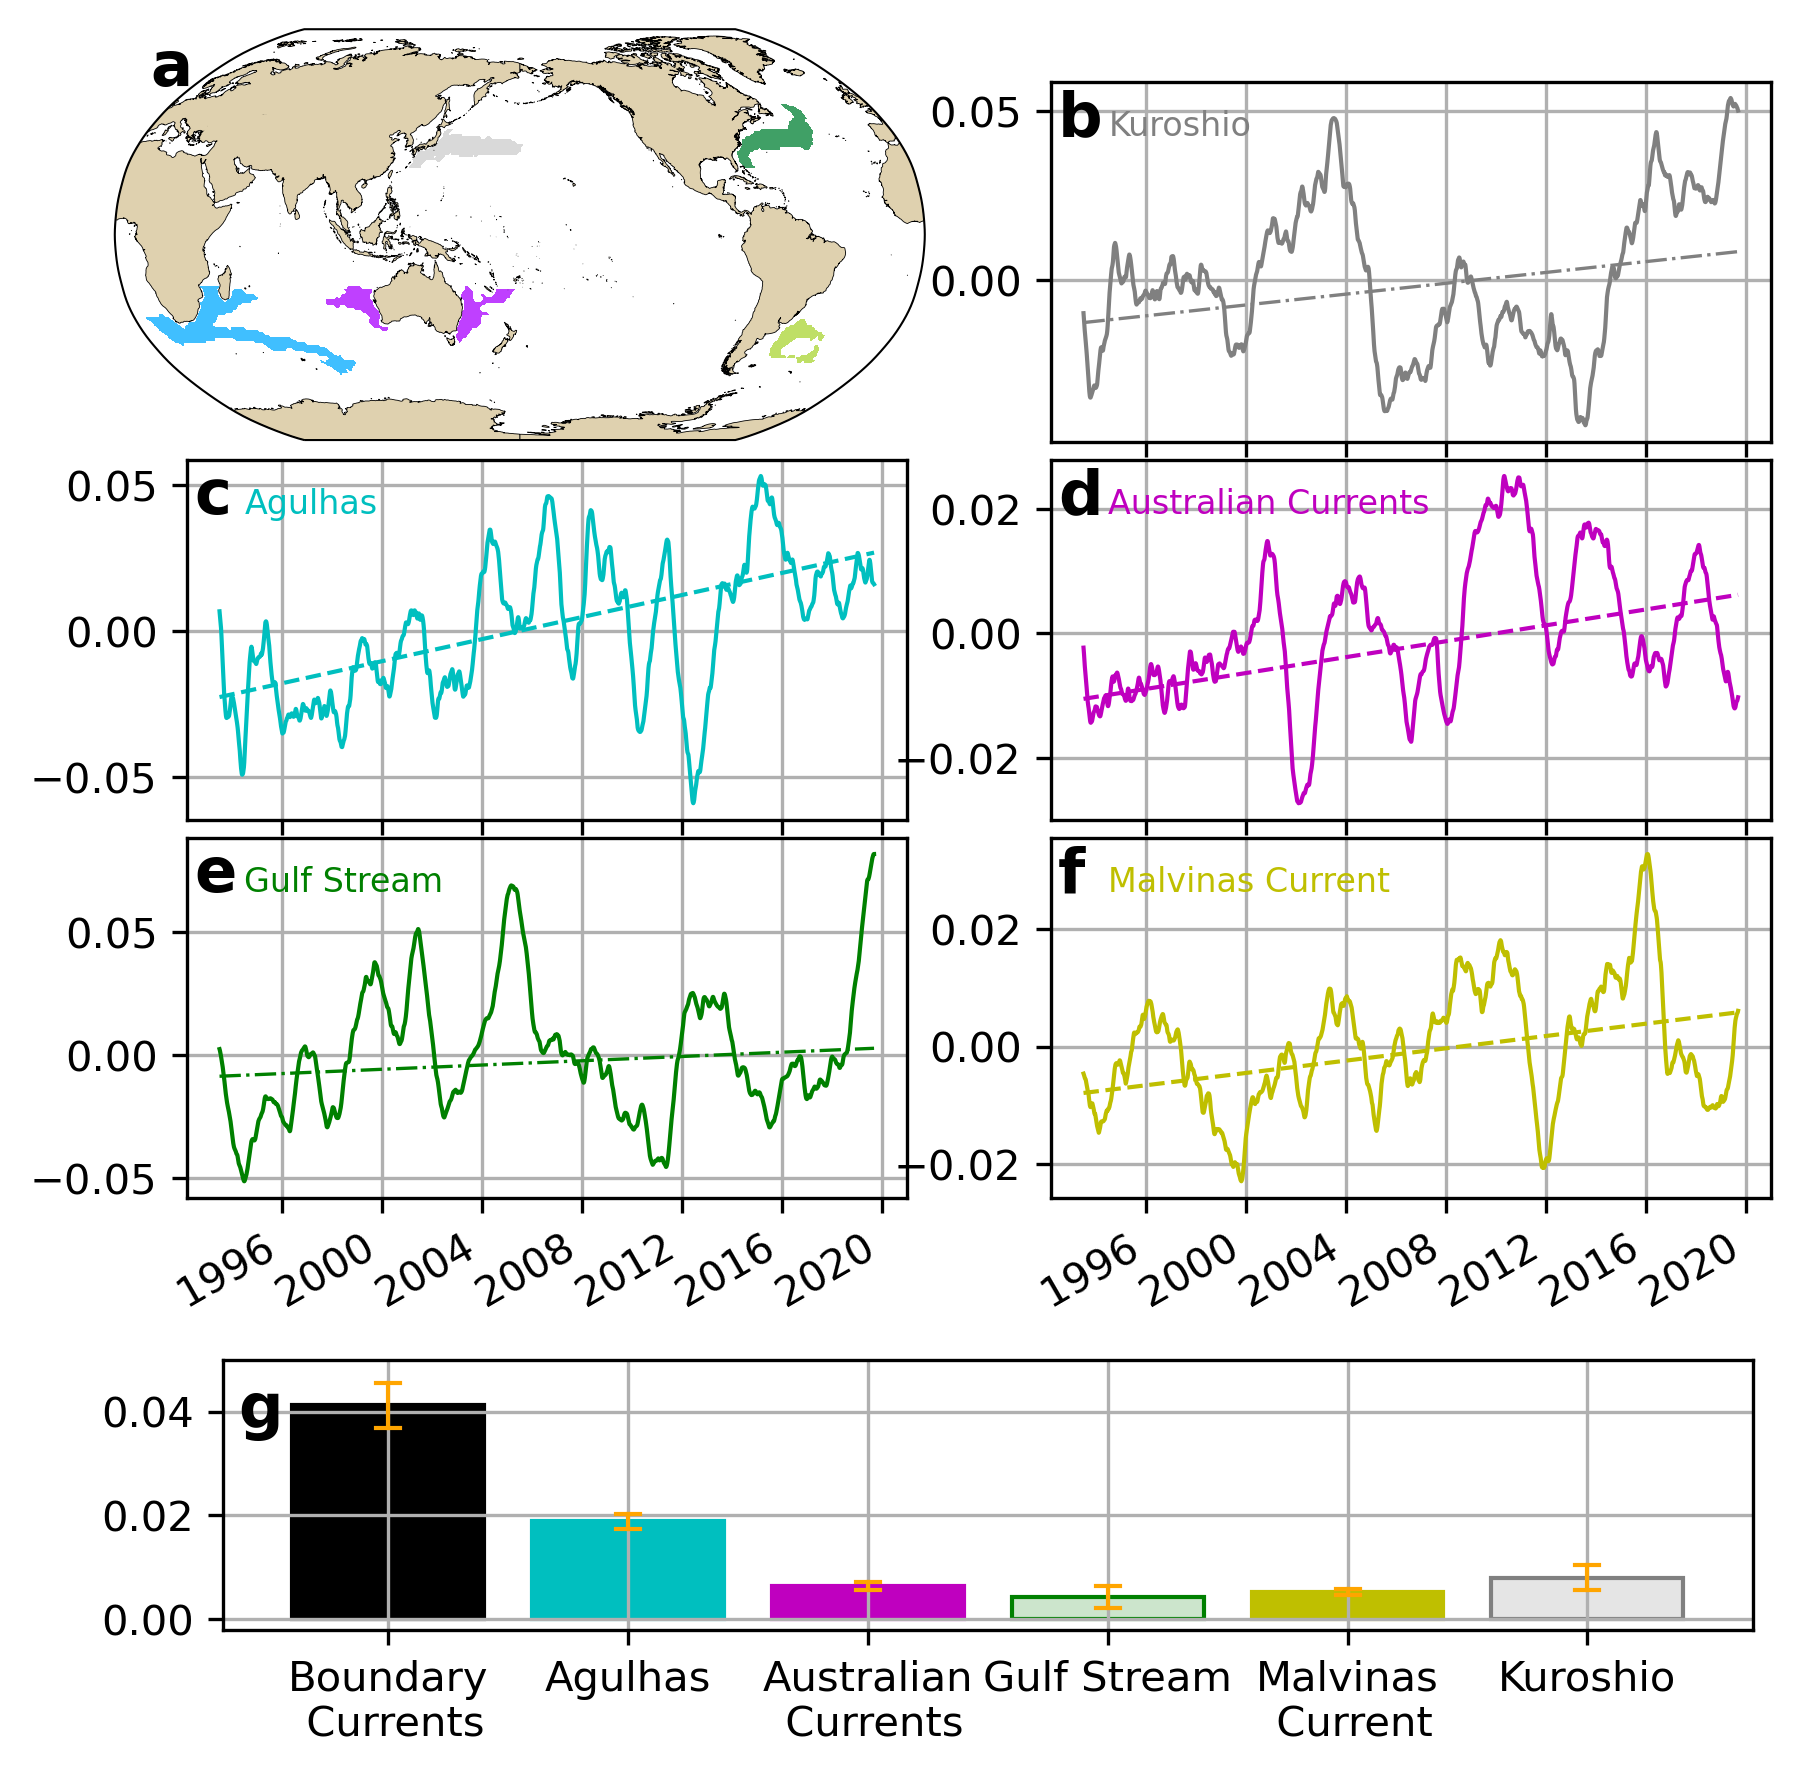

In [9]:
fig = plt.figure(figsize=(6, 6),dpi=300)

def config_axis(axis_list):
    for ii in range(len(axis_list)):
        if ii in [0,1]:
            plt.setp(axis_list[ii].get_xticklabels(), visible=False)
        axis_list[ii].set_xlabel('')
        axis_list[ii].set_ylabel('')

ax=fig.add_axes([0.04, 0.575, 0.45, 0.3],projection= ccrs.Robinson(central_longitude=180))

ax.contourf(b_mask.lon,b_mask.lat,b_mask.where(markers==1),cmap='cool',transform=ccrs.PlateCarree());

ax.contourf(b_mask.lon,b_mask.lat,b_mask.where(markers==3),cmap='cool_r',transform=ccrs.PlateCarree());

ax.contourf(b_mask.lon,b_mask.lat,b_mask.where(markers==6),cmap='summer',transform=ccrs.PlateCarree());

ax.contourf(b_mask.lon,b_mask.lat,b_mask.where(markers==2),cmap='summer_r',transform=ccrs.PlateCarree());

ax.contourf(b_mask.lon,b_mask.lat,b_mask.where(markers==5),cmap='Greys',transform=ccrs.PlateCarree());


add_patches(ax)

ax.set_global()
ax.add_feature(ccrs_land, zorder=2)
ax.spines['geo'].set_linewidth(0.5)

ax.set_title('')

###########################################################################
###########################################################################
###########################################################################

ax1 = fig.add_axes([0.08, 0.4, 0.4, 0.2])
ax2 = fig.add_axes([0.56, 0.4, 0.4, 0.2])
ax3 = fig.add_axes([0.08, 0.19, 0.4, 0.2])
ax4 = fig.add_axes([0.56, 0.19, 0.4, 0.2])
ax5 = fig.add_axes([0.56, 0.61, 0.4, 0.2])

axs=[ax1,ax2,ax3,ax4,ax5]
mask_values=[1,3,5,2,6]
colors=['c','m','g','y','gray']

slope=np.zeros(len(mask_values))
trends=[]

counts=0
linestyle=['--','--','-.','--','-.']
linewidth=[1,1,0.8,1,0.8]
for ax in axs:
    
    ig=dataset.where(markers[np.newaxis,:,:]==mask_values[counts]).sum(('lat','lon'))/1e15

    ig_nz=ig.where(ig!=0).dropna('time')

    trend=(ig_nz-ig_nz.mean()).dropna('time')
    trend.plot(ax=ax,linewidth=1,color=colors[counts])

    trends.append(trend)

    slope[counts], intercept = compute_trends(trend)
    ax.plot(trend.time,range(len(trend))*slope[counts]+intercept,linestyle[counts],linewidth=linewidth[counts],color=colors[counts])

    ax.set_xlabel('')
    ax.set_ylabel('TKE (TJ $m^{-1}$)',rotation=90)
    
    ax.grid()
    counts+=1

###########################################################################
###########################################################################
###########################################################################

ax5.plot(trend.time[0],0,'-c',label="Agulhas")
ax5.plot(trend.time[0],0,'-m',label="Kuroshio")
ax5.plot(trend.time[0],0,'-g',label="East Aus C")
ax5.plot(trend.time[0],0,'-y',label="Gulf Stream")
ax5.plot(trend.time[0],0,'-',color='gray',label="Maldivas C")

ax5.set_xticklabels([])

config_axis([ax1,ax2,ax3,ax4,ax5])

plt.subplots_adjust(hspace=0.4,wspace=0.4)

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.locator_params(axis='y', nbins=4)
        ax.tick_params(axis="both", labelsize=10)
        
format_axes(fig)

ax6 = fig.add_axes([0.1, -0.05, 0.85, 0.15])

globe_ts=dataset.where(markers[np.newaxis,:,:]!=0).sum(('lat','lon'))/1e15

globe_ts_nz=globe_ts.where(globe_ts!=0).dropna('time')
    
    
trend_globe=(globe_ts_nz-globe_ts_nz.mean()).dropna('time')
slope_g, intercept = compute_trends(trend_globe)

slopes_nt=np.hstack((np.array([slope_g]),slope))*10*365

colors=['k','c','m','g','y','gray']

ax6.bar([1,2,3,4,5,6],slopes_nt,color=colors)

integrated_timeseries = [trend_globe,trends[0],trends[1],
                        trends[2],trends[3],trends[4]]

integrated_timeseries_dataarray = xr.concat(integrated_timeseries,dim='x')

hypothesis,n_effective = significance_mk(integrated_timeseries_dataarray)

eke_std=np.std(integrated_timeseries,axis=1)
basins_nt_err=1.645*(eke_std/np.sqrt(n_effective))

for ii in range(1,7):
    plot_bars(ax6,ii,slopes_nt[ii-1],basins_nt_err[ii-1],width=0.05,linestyle='-',color='orange',linewidth=1)

for ii in range(0,6):
    if hypothesis[ii] == 1 or hypothesis[ii] == 2:
        pass
    else:
        patch = ax6.patches[ii]
        patch.set_alpha(0.2)
        

ax6.bar([1,2,3,4,5,6],slopes_nt,fill=False,linewidth=1,edgecolor=colors)
        
ax6.grid()
ax6.set_ylim(-0.002,0.050) 
ax6.set_xticks(range(1,7)) 
ax6.set_xticklabels(['Boundary\n Currents','Agulhas','Australian\n Currents','Gulf Stream','Malvinas\n Current','Kuroshio'])

ax.text(-1.25,0.99,'a',fontweight='bold',fontsize=15,transform=ax.transAxes)
ax1.text(0.01,0.85,'c',fontweight='bold',fontsize=15,transform=ax1.transAxes)
ax2.text(0.01,0.85,'d',fontweight='bold',fontsize=15,transform=ax2.transAxes)
ax3.text(0.01,0.85,'e',fontweight='bold',fontsize=15,transform=ax3.transAxes)
ax4.text(0.01,0.85,'f',fontweight='bold',fontsize=15,transform=ax4.transAxes)
ax5.text(0.01,0.85,'b',fontweight='bold',fontsize=15,transform=ax5.transAxes)
ax6.text(0.01,0.75,'g',fontweight='bold',fontsize=15,transform=ax6.transAxes)

ax1.text(0.08,0.85,'Agulhas',fontsize=8,transform=ax1.transAxes,color='c')
ax2.text(0.08,0.85,'Australian Currents',fontsize=8,transform=ax2.transAxes,color='m')
ax3.text(0.08,0.85,'Gulf Stream',fontsize=8,transform=ax3.transAxes,color='g')
ax4.text(0.08,0.85,'Malvinas Current',fontsize=8,transform=ax4.transAxes,color='y')
ax5.text(0.08,0.85,'Kuroshio',fontsize=8,transform=ax5.transAxes,color='gray')

plt.savefig('../../LaTeX/figures/global_wbc_decomposition_trends.pdf',dpi=300,bbox_inches='tight')